In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/Snake_Input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pygame
import random
from enum import Enum
from collections import namedtuple

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple("Point", "x, y")


pygame.display.init()
pygame.font.init()
font = pygame.font.Font(pygame.font.get_default_font(), 25)

WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 20
SPEED = 120


class SnakeGame:
  def __init__(self, width=640, height=480, playerName="Player"):
    self.w = width
    self.h = height
    self.playerName = playerName
    self.display = pygame.display.set_mode((self.w, self.h))
    pygame.display.set_caption("AI Snake Trainer")
    self.clock = pygame.time.Clock()

    self.direction = Direction.RIGHT
    self.head = Point(self.w/2, self.h/2)
    self.snake = [self.head, Point(self.head.x-BLOCK_SIZE, self.head.y), Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]
    self.score = 0
    self.food = None
    self.placeFood()
    self.frameIteration = 0

  def reset(self):
    self.direction = Direction.RIGHT
    self.head = Point(self.w/2, self.h/2)
    self.snake = [self.head, Point(self.head.x-BLOCK_SIZE, self.head.y), Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]
    self.score = 0
    self.food = None
    self.placeFood()
    self.frameIteration = 0




  def placeFood(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self.placeFood()


  def playStep(self, action):
    self.frameIteration += 1
    for event in pygame.event.get():
        if event == pygame.QUIT:
            pygame.quit()
            quit()
    self.moveSnake(action)
    reward = 0
    if self.isCollision() or self.frameIteration > 100 * len(self.snake):
      gameOver = True
      reward -= 10
      return reward, gameOver, self.score

    if self.head == self.food:
      self.score += 1
      reward = 10
      self.placeFood()
    else:
      self.snake.pop()

    self.updateUi()
    self.clock.tick(SPEED)


    gameOver = False
    return reward, gameOver, self.score



  def isCollision(self, p: Point = None):
    if p == None:
      p = self.head
    if p.x > self.w - BLOCK_SIZE or p.x < 0:
      return True
    if p.y > self.h - BLOCK_SIZE or p.y < 0:
      return True
    if p in self.snake[1:]:
      return True
    return False

  def moveSnake(self, action):
    clockWiseDirections = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
    currentDirectionIndex = clockWiseDirections.index(self.direction)
    newDirection = self.direction

    if np.array_equal(action, [0, 1, 0]):
      newDirection = clockWiseDirections[(currentDirectionIndex + 1) % 4]
    elif np.array_equal(action, [1, 0, 0]):
      newDirection = clockWiseDirections[(currentDirectionIndex - 1) % 4]

    self.direction = newDirection
    x = self.head.x
    y = self.head.y

    if self.direction == Direction.RIGHT:
      x += BLOCK_SIZE
    elif self.direction == Direction.LEFT:
      x -= BLOCK_SIZE
    elif self.direction == Direction.DOWN:
      y += BLOCK_SIZE
    elif self.direction == Direction.UP:
      y -= BLOCK_SIZE

    self.head = Point(x, y)
    self.snake.insert(0, self.head)


  def setPlayerName(self, name):
        self.playerName = name

  def updateUi(self):
    self.display.fill(BLACK)
    for pt in self.snake:
      pygame.draw.rect(self.display, BLUE1, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
      pygame.draw.rect(self.display, BLUE2, pygame.Rect(pt.x+4, pt.y+4, 12, 12))

    pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))
    scoreText = font.render("Score: " + str(self.score) + " Speed: " + str(SPEED) + " Player: " + self.playerName, True, WHITE)
    self.display.blit(scoreText, [0, 0])
    pygame.display.flip()


pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LinearQNet(nn.Module):
  def __init__(self, inputSize, hiddenSize, outputSize):
    super().__init__()
    self.linear1 = nn.Linear(inputSize, hiddenSize)
    self.linear2 = nn.Linear(hiddenSize, outputSize)

  def forward(self, x):
    out = self.linear1(x)
    out = F.relu(out)
    return self.linear2(out)



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QTrainer:
  def __init__(self, default_model, learning_rate, gamma):
    self.model = default_model
    self.lr = learning_rate
    self.gamma = gamma
    self.optimizer = optim.Adam(default_model.parameters(), self.lr)
    self.lossFunction = nn.MSELoss()

  def trainStep(self, state, action, reward, newState, done):
    stateTensor = torch.tensor(state, dtype=torch.float)
    actionTensor = torch.tensor(action, dtype=torch.long)
    rewardTensor = torch.tensor(reward, dtype=torch.float)
    newStateTensor = torch.tensor(newState, dtype=torch.float)

    if len(stateTensor.shape) == 1:
      stateTensor = torch.unsqueeze(stateTensor, 0)
      actionTensor = torch.unsqueeze(actionTensor, 0)
      rewardTensor = torch.unsqueeze(rewardTensor, 0)
      newStateTensor = torch.unsqueeze(newStateTensor, 0)
      done = (done, )

    pred = self.model(stateTensor)
    target = pred.clone()

    for i in range(len(done)):
      Q_new = rewardTensor[i]
      if not done[i]:
        Q_new = rewardTensor[i] + self.gamma * torch.max(self.model(newStateTensor[i]))
      target[i][torch.argmax(actionTensor).item()] = Q_new


    self.optimizer.zero_grad()
    loss = self.lossFunction(target, pred)
    loss.backward()
    self.optimizer.step()

In [10]:
import torch
import random
import numpy as np
from collections import deque

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 1e-3

class Agent:
  def __init__(self):
    self.numberOfGames = 0
    self.epsilon = 0
    self.gamma = 0.9
    self.memory = deque(maxlen=MAX_MEMORY)
    self.model = LinearQNet(11, 256, 3)
    self.trainer = QTrainer(self.model, learning_rate=LR, gamma=self.gamma)

  def getState(self, game):
    head = game.head
    point_left = Point(head.x - BLOCK_SIZE, head.y)
    point_right = Point(head.x + BLOCK_SIZE, head.y)
    point_up = Point(head.x, head.y - BLOCK_SIZE)
    point_down = Point(head.x, head.y + BLOCK_SIZE)

    direction_left = game.direction == Direction.LEFT
    direction_right = game.direction == Direction.RIGHT
    direction_up = game.direction == Direction.UP
    direction_down = game.direction == Direction.DOWN

    state = [
      (direction_right and game.isCollision(point_right)) or
      (direction_left and game.isCollision(point_left)) or
      (direction_up and game.isCollision(point_up)) or
      (direction_down and game.isCollision(point_down)),

      (direction_up and game.isCollision(point_right)) or
      (direction_down and game.isCollision(point_left)) or
      (direction_left and game.isCollision(point_up)) or
      (direction_right and game.isCollision(point_down)),

      (direction_down and game.isCollision(point_right)) or
      (direction_up and game.isCollision(point_left)) or
      (direction_right and game.isCollision(point_up)) or
      (direction_left and game.isCollision(point_down)),

      direction_left,
      direction_right,
      direction_up,
      direction_down,

      game.food.x < game.head.x,  # food left
      game.food.x > game.head.x,  # food right
      game.food.y < game.head.y,  # food up
      game.food.y > game.head.y  # food down
      ]

    return np.array(state, dtype=int)

  def remember(self, state, action, reward, nextState, done):
    self.memory.append((state, action, reward, nextState, done))

  def trainLongMemory(self):
    if len(self.memory) < BATCH_SIZE:
      sample = self.memory
    else:
      sample = random.sample(self.memory, BATCH_SIZE)

    states, actions, rewards, nextStates, dones = zip(*sample)
    self.trainer.trainStep(states, actions, rewards, nextStates, dones)

  def trainShortMemory(self, state, action, reward, nextState, done):
    self.trainer.trainStep(state, action, reward, nextState, done)

  def getAction(self, state):
    self.epsilon = 80 - self.numberOfGames
    finalMove = [0, 0, 0]
    if random.randint(0, 200) < self.epsilon:
      move = random.randint(0, 2)
      finalMove[move] = 1
    else:
      stateTensor = torch.tensor(state, dtype=torch.float)
      prediction = self.model(stateTensor)
      move = torch.argmax(prediction).item()
      finalMove[move] = 1

    return finalMove


In [11]:
%%time

scoresHistory = []
meanScores = []

def train():
  totalScore = 0
  bestScore = 0
  agent = Agent()
  game = SnakeGame()

  while agent.numberOfGames < 200:
    game.setPlayerName("Machine epoch " + str(agent.numberOfGames))
    oldState = agent.getState(game)
    finalMove = agent.getAction(oldState)
    reward, done, score = game.playStep(finalMove)
    newState = agent.getState(game)
    agent.trainShortMemory(oldState, finalMove, reward, newState, done)
    agent.remember(oldState, finalMove, reward, newState, done)

    if done:
      game.reset()
      agent.numberOfGames += 1
      agent.trainLongMemory()

      if score > bestScore:
        bestScore = score

      totalScore += score
      meanScore = (totalScore / agent.numberOfGames)

      scoresHistory.append(score)
      meanScores.append(meanScore)

      if score == bestScore or agent.numberOfGames % 10 == 0:
        print("Game number: ", agent.numberOfGames, "Score: ", score, "Best Score: ", bestScore, "Mean scores: ", meanScore)

train()

C:\Users\13018\AppData\Local\Temp\ipykernel_39304\3639043675.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  stateTensor = torch.tensor(state, dtype=torch.float)


Game number:  1 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  2 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  3 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  4 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  5 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  6 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  7 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  8 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  9 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  10 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  11 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  12 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  13 Score:  1 Best Score:  1 Mean scores:  0.07692307692307693
Game number:  16 Score:  1 Best Score:  1 Mean scores:  0.125
Game number:  18 Score:  1 Best Score:  1 Mean scores:  0.16666666666666666
Game number:  20 Score:  1 Best Score:  1 Mean scores:  0.2
Game number:  2

Text(0, 0.5, 'Game Score')

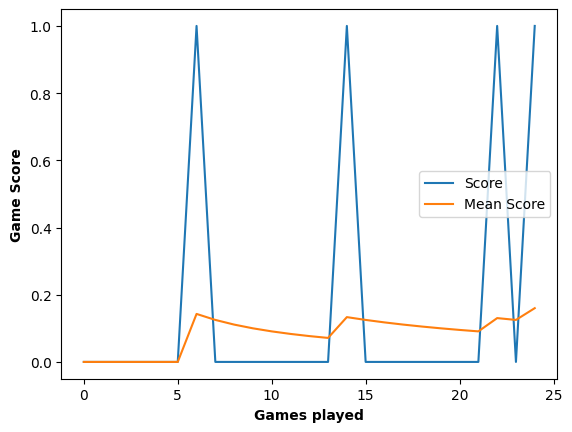

In [12]:
import matplotlib.pyplot as plt

plt.plot(scoresHistory)
plt.plot(meanScores)
plt.legend(["Score", "Mean Score"])
plt.xlabel('Games played',
               fontweight ='bold')
plt.ylabel('Game Score',
               fontweight ='bold')